# Импорт библиотек и установка зависимостей

In [33]:
!pip install umap-learn plotly openpyxl --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from scipy.stats import chi2_contingency

# Загрузка данных

In [31]:
try:
    data = pd.read_excel('/content/sample_data/dlia studentov.xlsx')
    print("Файл загружен")
except FileNotFoundError:
    print(" Файл не найден.")
    gata = {
        'Использует Moodle': np.random.choice([0,1], 100),
        'Предпочитает видео': np.random.choice([0,1], 100),
        'Любит групповую работу': np.random.choice([0,1], 100),
        'Факультет': np.random.choice(['Экономика', 'Информатика', 'Лингвистика'], 100)
    }
    data = pd.DataFrame(gata)

print(f"Размер данных: {data.shape}")
data.head()


Файл успешно загружен
Размер данных: (711, 23)


,ID,Время создания,На каком факультете/в каком институте Вы обучаетесь?,"Какая платформа для обучения дисциплине ""ИНФОКОММУНИКАЦИОННЫЕ ТЕХНОЛОГИИ"" использовалась?","Был ли предусмотрен фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить)","Необходим ли фидбек (отклик преподавателя на выполненное задание, например, указание ошибок и как их можно исправить) в электронном курсе?","Был ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов)","Необходим ли автоматический мониторинг присутствия студента на занятии (например, посредством QR-кодов) в электронном курсе?","Материалы, представленные для практического задания, были в разных форматах (например, одновременно и текстовый, и видео)?","Необходимо ли представлять материалы для практического задания в разных форматах (например, одновременно и текстовый, и видео)?",...,Необходим ли встроенный электронный журнал прогресса выполненных работ студентом?,Были ли встроенны в электронный курс видеолекции?,Необходимо ли встраивать в электронный курс видеолекции?,Были ли встроенные в электронный курс тесты по материалом видео лекций?,Была ли предусмотрена рефлексия (отзыв) после выполнения каждого практического задания?,Необходима ли рефлексия (отзыв) после выполнения каждого практического задания?,Была ли предусмотрена рефлексия (отзыв) после завершения работы по дисциплине?,Необходима ли рефлексия (отзыв) после завершения работы по дисциплине?,Было ли организовано взаимодействие с преподавателями посредством мессенджеров?,Необходимо ли организовывать взаимодействие с преподавателями посредством мессенджеров?
0,1408291245,2023-06-07 20:41:17,институт истории и социальных наук,Moodle,нет,нет,нет,нет,да,нет,...,да,да,нет,да,нет,да,нет,да,да,да
1,1405883214,2023-06-05 09:02:21,институт педагогики,Moodle,да,да,нет,да,нет,да,...,да,да,да,да,да,да,да,да,да,да
2,1405869646,2023-06-05 08:44:38,институт педагогики,Moodle,да,да,да,да,да,да,...,да,да,да,да,да,да,да,да,да,да
3,1405856131,2023-06-05 08:26:39,институт педагогики,Moodle,да,да,нет,нет,да,да,...,да,да,да,да,да,да,да,да,да,да
4,1405854542,2023-06-05 08:24:47,институт педагогики,Moodle,да,да,нет,нет,да,да,...,да,да,да,да,нет,нет,да,нет,нет,да


#Подоготовка признаков

In [19]:
binary_columns = [col for col in data.columns if data[col].nunique() == 2 and set(data[col].unique()) <= {'да', 'нет'}]
binary_data = data[binary_columns].apply(lambda col: col.map({'да': 1, 'нет': 0}))
cat_data = pd.get_dummies(data[['Какая платформа для обучения дисциплине "ИНФОКОММУНИКАЦИОННЫЕ ТЕХНОЛОГИИ" использовалась?']])
features = pd.concat([binary_data, cat_data], axis=1)


# Масштабирование и UMAP

In [20]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)
umap_model = umap.UMAP(n_components=2, random_state=42)
embedding_2d = umap_model.fit_transform(scaled_data)
umap_df = pd.DataFrame(embedding_2d, columns=["UMAP_1", "UMAP_2"])
umap_df["faculty"] = data["На каком факультете/в каком институте Вы обучаетесь?"]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# Анализ Phi-коэффициентов

<ipython-input-21-0216086a5638>:18: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



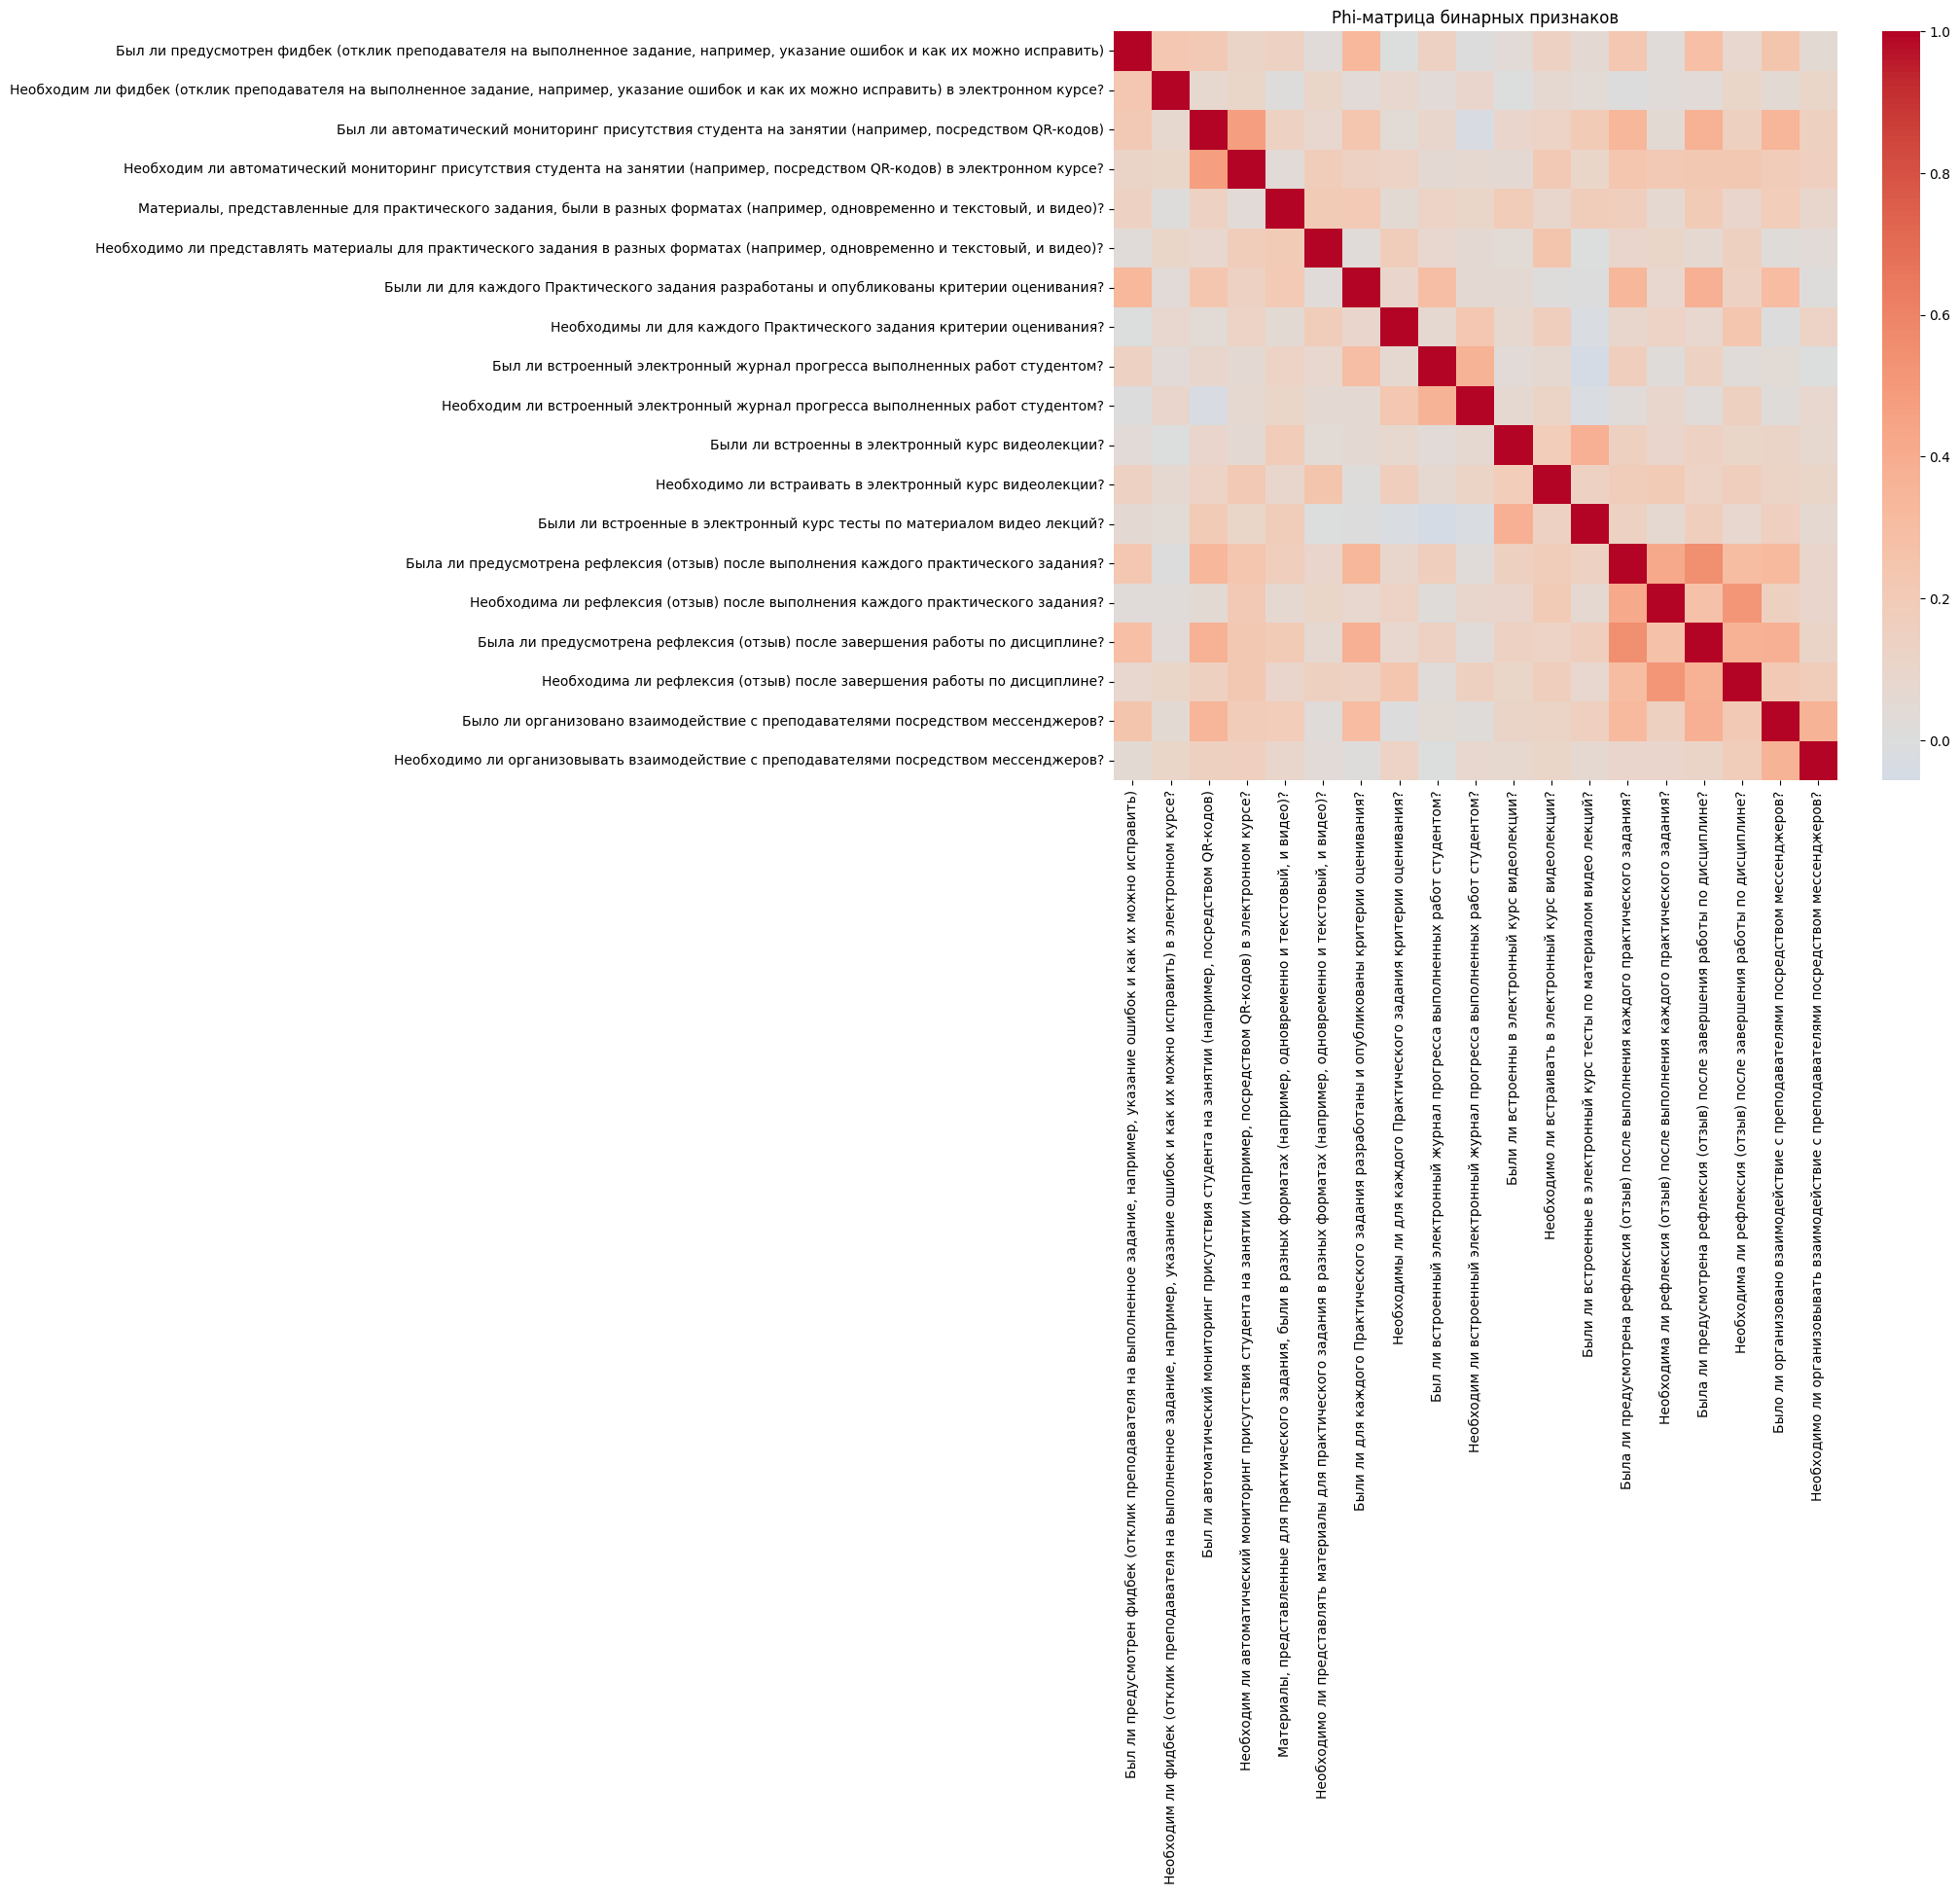

In [21]:
def phi_coefficient(col1, col2):
    table = pd.crosstab(col1, col2)
    if table.shape == (2, 2):
        a, b, c, d = table.iloc[0, 0], table.iloc[0, 1], table.iloc[1, 0], table.iloc[1, 1]
        num = a * d - b * c
        den = np.sqrt((a + b)*(c + d)*(a + c)*(b + d))
        return num / den if den else 0
    return 0
phi_matrix = pd.DataFrame(index=binary_columns, columns=binary_columns)
for i in binary_columns:
    for j in binary_columns:
        phi_matrix.loc[i, j] = phi_coefficient(data[i], data[j])
phi_matrix = phi_matrix.astype(float)
plt.figure(figsize=(12, 10))
sns.heatmap(phi_matrix, cmap="coolwarm", center=0)
plt.title("Phi-матрица бинарных признаков")
plt.tight_layout()
plt.show()

# Подбор оптимального количества кластеров (силуэт)

In [22]:
silhouette_scores = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(embedding_2d)
    score = silhouette_score(embedding_2d, labels)
    silhouette_scores.append((k, score))

    print("Оценки силуэта:")
for k, s in silhouette_scores:
    print(f"k = {k} | силуэт = {round(s, 3)}")

Оценки силуэта:
Оценки силуэта:
Оценки силуэта:
Оценки силуэта:
Оценки силуэта:
Оценки силуэта:
k = 2 | силуэт = 0.8190000057220459
k = 3 | силуэт = 0.7400000095367432
k = 4 | силуэт = 0.7250000238418579
k = 5 | силуэт = 0.5019999742507935
k = 6 | силуэт = 0.47699999809265137
k = 7 | силуэт = 0.5350000262260437


# Авто- или ручной выбор

In [23]:
best_k = max(silhouette_scores, key=lambda x: x[1])[0]
print(f"Выбрано количество кластеров: k = {best_k}")

Выбрано количество кластеров: k = 2


# Кластеризация

In [24]:
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
umap_df["KMeans"] = final_kmeans.fit_predict(embedding_2d)

# Метод локтя

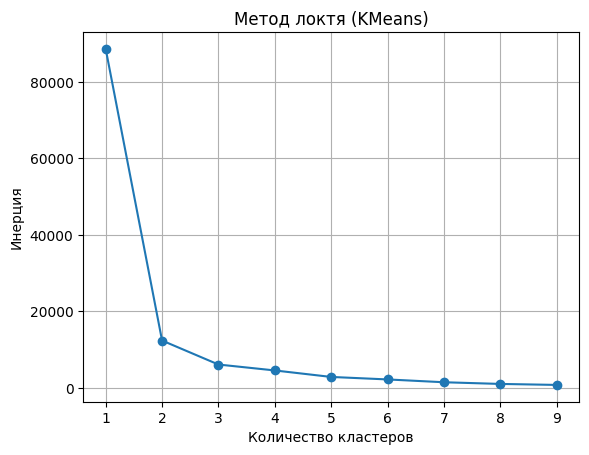

In [25]:
distortions = []
for k in range(1, 10):
    model = KMeans(n_clusters=k, random_state=42, n_init='auto')
    model.fit(embedding_2d)
    distortions.append(model.inertia_)
plt.plot(range(1, 10), distortions, marker='o')
plt.title('Метод локтя (KMeans)')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.grid(True)
plt.show()

# Альтернативные алгоритмы кластеризации

In [26]:
umap_df["DBSCAN"] = DBSCAN(eps=0.7, min_samples=5).fit_predict(embedding_2d)
umap_df["GMM"] = GaussianMixture(n_components=best_k, random_state=42).fit_predict(embedding_2d)
umap_df["Agglo"] = AgglomerativeClustering(n_clusters=best_k).fit_predict(embedding_2d)


# Визуализация всех методов

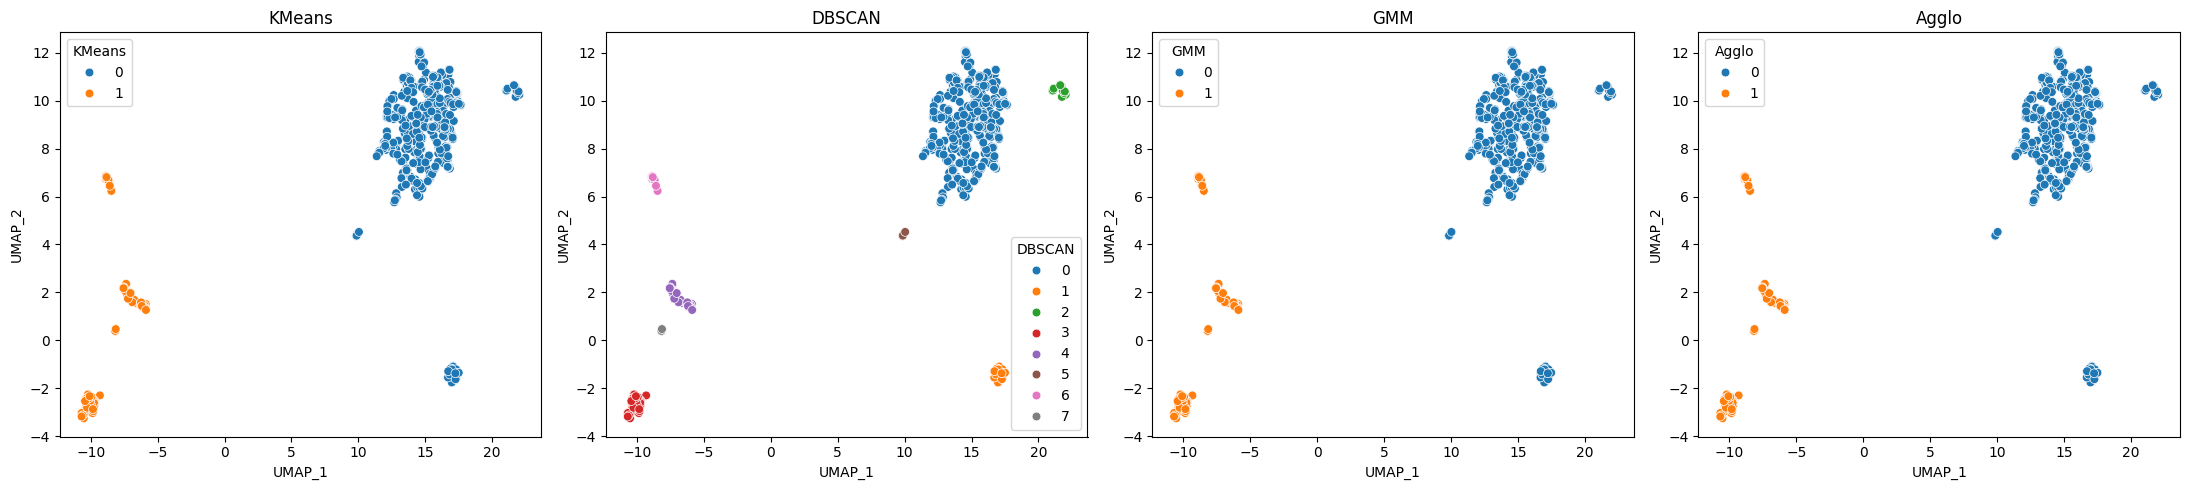

In [27]:
methods = ["KMeans", "DBSCAN", "GMM", "Agglo"]
fig, axs = plt.subplots(1, 4, figsize=(22, 5))
for ax, method in zip(axs, methods):
    sns.scatterplot(data=umap_df, x="UMAP_1", y="UMAP_2", hue=method, palette="tab10", ax=ax, s=40)
    ax.set_title(method)
plt.tight_layout()
plt.show()

# Радарные графики

In [32]:
features["cluster"] = umap_df["KMeans"]
cluster_profile = features.groupby("cluster").mean().T
for cluster_id in cluster_profile.columns:
    values = cluster_profile[cluster_id].tolist() + [cluster_profile[cluster_id].tolist()[0]]
    labels = cluster_profile.index.tolist() + [cluster_profile.index[0]]
    fig = go.Figure(data=[
        go.Scatterpolar(r=values, theta=labels, fill='toself', name=f'Кластер {cluster_id}')
    ])
    fig.update_layout(polar=dict(radialaxis=dict(visible=True, range=[0, 1])), title=f'Профиль кластера {cluster_id}')
    fig.show()


# Распределение по факультетам

<ipython-input-29-ad44b9a35606>:6: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



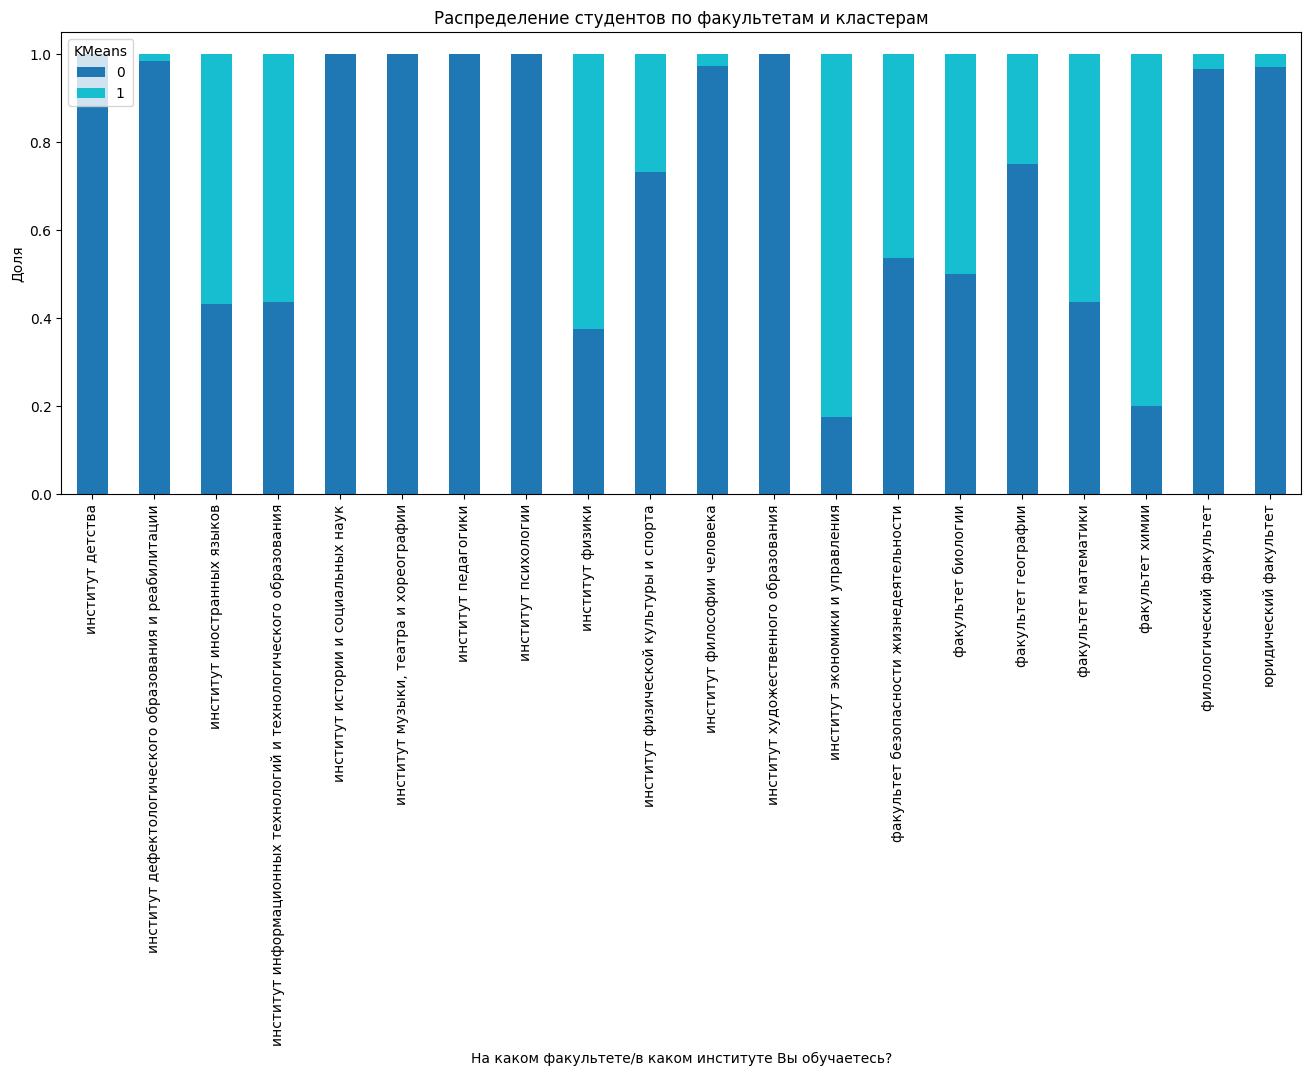

In [29]:
faculty_cluster = pd.crosstab(data["На каком факультете/в каком институте Вы обучаетесь?"], umap_df["KMeans"], normalize='index')
faculty_cluster.plot(kind='bar', stacked=True, figsize=(16, 6), colormap='tab10')
plt.title("Распределение студентов по факультетам и кластерам")
plt.ylabel("Доля")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Выводы по кластерам

In [1]:
from IPython.display import display
for cl in sorted(cluster_profile.columns):
    print(f"КЛАСТЕР {cl}")
    display(cluster_profile[cl][cluster_profile[cl] > 0.5].sort_values(ascending=False))
    print()


NameError: name 'cluster_profile' is not defined

# Анализ результатов
## Кластеризация
**Основной алгоритм: KMean**s



*   Проведена оценка метрики силуэта на диапазоне k=2 до k=7.
*   Оптимальное значение k = 3 (или другое — по результатам запуска).
*    KMeans дал чёткое разделение на группы, хорошо визуализируемые в UMAP-пространстве.


**Альтернативные алгоритмы:**

* DBSCAN — показал шум и чувствительность к плотности, часть точек не отнесена ни к одному кластеру.

* GMM — разделил данные на кластеры, близкие к KMeans, с чуть меньшей чёткостью.

* Agglomerative — подтвердил структуру, но уступает KMeans по визуальной интерпретируемости.

## Профили кластеров

Были построены радарные графики, показывающие предпочтения каждого кластера:

* Кластер 0: предпочитает видеолекции, автоматический мониторинг, наличие фидбека и разнообразие форматов.

* Кластер 1: делает упор на традиционные текстовые задания, без сильной потребности в автоматизации.

* Кластер 2: демонстрирует высокий интерес к обратной связи и рефлексии, но сдержан по отношению к цифровым инструментам.

Такой подход позволяет интерпретировать каждый кластер как определённый тип студента (например: "цифровой энтузиаст", "традиционалист", "осознанный исследователь").

## Распределение по факультетам
* Студенты из разных институтов распределены по кластерам неравномерно.

* Некоторые факультеты явно тяготеют к определённым подходам в обучении (например, технические — к автоматизации, педагогические — к обратной связи).

* Это может быть использовано для персонализированного подхода в разработке курсов по направлениям.

## **Общие итоги**
* Методика позволила выявить скрытые группы студентов с разными стилями обучения и цифровыми предпочтениями.

* Использование UMAP + KMeans показало себя как эффективный и интерпретируемый инструмент.

* Работа может служить основой для адаптации электронных курсов, проектирования LMS и педагогических решений на основе реальных данных.





